<a href="https://colab.research.google.com/github/ma2sevich222/raw_stock_data_researches/blob/main/only_buy_siemese_patten_recognition_ipynb__.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from pandas import read_csv
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, concatenate, LSTM, Reshape, Dense,BatchNormalization,Flatten
from math import log
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import numpy as np
from itertools import accumulate
from math import log
import matplotlib.pyplot as plt 
import tensorflow.keras as keras
import tensorflow as tf
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
import random
from keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Activation,AveragePooling2D
from keras import backend as K
from scipy.signal import argrelextrema
from sklearn.preprocessing import normalize
from keras.models import save_model
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/LOB_F_eng
!pwd

/content/drive/MyDrive/LOB_F_eng
/content/drive/MyDrive/LOB_F_eng


#Загрузка и подготовка данных

In [ ]:
DATA=pd.read_csv('VZ 15 Minutes (with indicators).txt', delimiter = ",")
NEW_DATA=DATA[['<Date>',' <Time>',' <Open>', ' <High>',' <Low>',' <Close>',' <Volume>']].copy()
names = NEW_DATA.columns.to_list()
for col in names:
  print(col,(NEW_DATA[col] == 0).sum())

NEW_DATA=NEW_DATA[~(NEW_DATA == 0).any(axis=1)]
Date=pd.to_datetime(NEW_DATA['<Date>'] + NEW_DATA[' <Time>'], format='%d.%m.%Y%H:%M:%S')
NEW_DATA.drop(['<Date>', ' <Time>'], axis = 1, inplace = True) 
NEW_DATA.insert(0,'Date',Date)
NEW_DATA.columns = ['Date','Open', 'High', 'Low', 'Close', 'Volume']
NEW_DATA=NEW_DATA[['Date','Open', 'High', 'Low', 'Close', 'Volume']]
NEW_DATA['SMA'] =NEW_DATA.iloc[:,3].rolling(window=10).mean()
NEW_DATA['CMA30'] = NEW_DATA['Close'].expanding().mean()
NEW_DATA['SMA']=NEW_DATA['SMA'].fillna(0)

<Date> 0
 <Time> 0
 <Open> 0
 <High> 0
 <Low> 0
 <Close> 0
 <Volume> 4


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
NEW_DATA.head()

,Date,Open,High,Low,Close,Volume,SMA,CMA30
0,2018-01-02 09:45:00,53.160,53.35,52.920,52.96,895725,0.0,52.960000
1,2018-01-02 10:00:00,52.950,53.16,52.800,53.12,884034,0.0,53.040000
2,2018-01-02 10:15:00,53.125,53.26,53.035,53.24,435119,0.0,53.106667
3,2018-01-02 10:30:00,53.240,53.35,53.170,53.34,545240,0.0,53.165000
4,2018-01-02 10:45:00,53.340,53.48,53.290,53.46,417159,0.0,53.224000


In [ ]:
Train_df=NEW_DATA[:10000]
Eval_df=NEW_DATA[10000:]
Train_dates=Train_df[['Date']]
Eval_dates=Eval_df[['Date']]
Train_df.drop(['Date'], axis = 1, inplace = True)
Eval_df.drop(['Date'], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
'''Основыен параметры'''

num_classes=2
extr_window=40
n_size=20 #размер мемори

In [ ]:
def get_locals(data_df,n): # данные подаются в формате df




  data_df['index1'] = data_df.index


  data_df['min']=data_df.iloc[argrelextrema(data_df.Close.values, np.less_equal,
                    order=n)[0]]['Close']



  data_df['max'] = data_df.iloc[argrelextrema(data_df.Close.values, np.greater_equal,
                    order=n)[0]]['Close']



  f = plt.figure()
  f.set_figwidth(80)
  f.set_figheight(65)

  plt.scatter(data_df.index1, data_df['min'], c='r')
  plt.scatter(data_df.index1, data_df['max'], c='g')
  plt.plot(data_df.index1, data_df['Close'])

 
  plt.show()


  Min_=data_df.loc[data_df['min'].isnull() == False]
  Min_.reset_index(inplace=True)
  Min_.drop(['max'],axis=1,inplace=True)


  Max_=data_df.loc[data_df['max'].isnull() == False]
  Max_.reset_index(inplace=True)
  Max_.drop(['min'],axis=1,inplace=True)


  data_df.drop(['index1', 'min','max'], axis = 1, inplace = True)



  return Min_,Max_ 



In [ ]:
def get_patterns(data,min_indexes,max_indexes,n_backwatch):# подаем дата как нумпи, индексы как лист


  negative_patterns=[]
  positive_patterns=[]



  for ind in min_indexes:

    if ind-n_backwatch>=0:
      neg=data[(ind-n_backwatch):ind]
      negative_patterns.append(neg)
  


  for ind in max_indexes:

    if ind-(2*n_backwatch)>=0:
      pos=data[(ind-n_backwatch):ind]
      positive_patterns.append(pos)



  negative_patterns=np.array(negative_patterns)
  positive_patterns=np.array(positive_patterns)


  return negative_patterns,positive_patterns

  




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

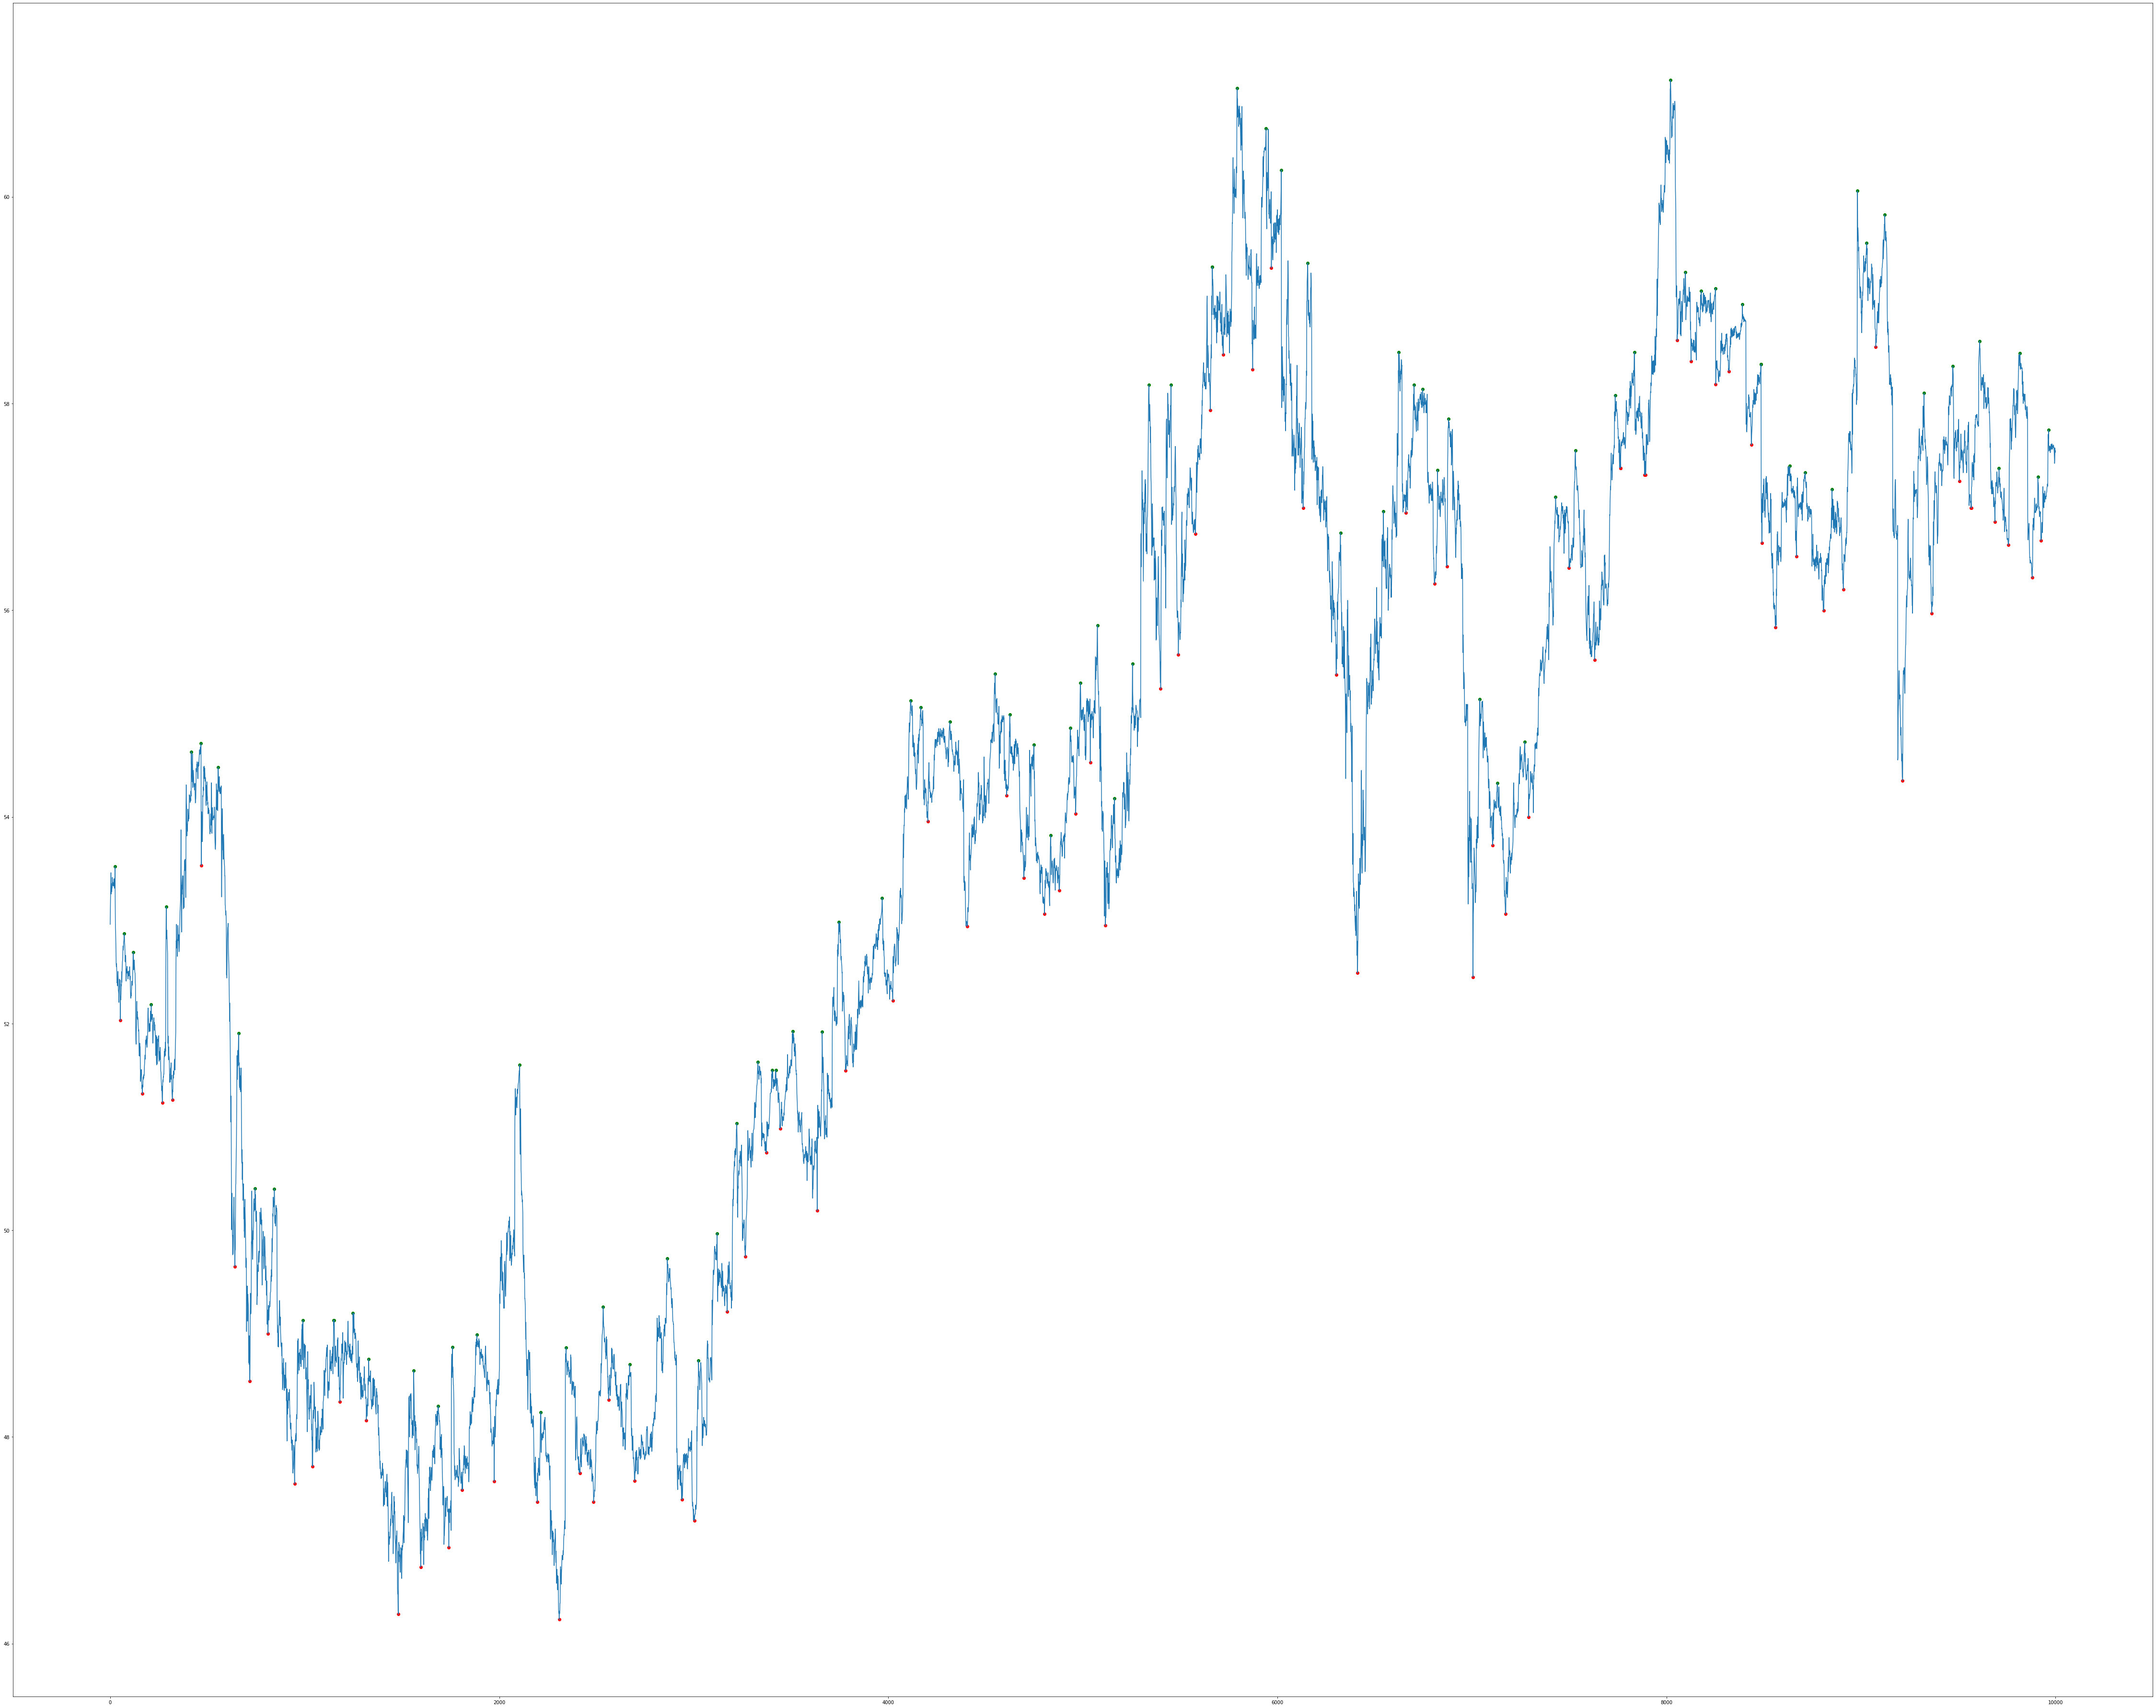

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
Min_train_locals,Max_train__locals=get_locals(Train_df,extr_window)

In [ ]:
neg_patern,pos_patern=get_patterns(Train_df.to_numpy(),Min_train_locals['index1'].values.tolist(),Max_train__locals['index1'].values.tolist(),n_size)

In [ ]:
neg_patern.shape

(84, 20, 7)

In [ ]:
pos_patern.shape

(89, 20, 7)

# Функции для сети

In [ ]:
def euclid_dis(vects):
  x,y = vects
  sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [ ]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [ ]:
def contrastive_loss(y_true, y_pred):
    y_true=tf.dtypes.cast(y_true, tf.float64)
    y_pred=tf.dtypes.cast(y_pred, tf.float64)
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [ ]:
def create_pairs(x, digit_indices):
  pairs = []
  labels = []
   
  n=min([len(digit_indices[d]) for d in range(num_classes)]) -1
   
  for d in range(num_classes):
    for i in range(n):
      z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
      pairs += [[x[z1], x[z2]]]
      inc = random.randrange(1, num_classes)
      dn = (d + inc) % num_classes
      z1, z2 = digit_indices[d][i], digit_indices[dn][i]
      pairs += [[x[z1], x[z2]]]
      labels += [1,0]
  return np.array(pairs), np.array(labels)

In [ ]:
def create_base_net(input_shape):
   
  input = Input(shape = input_shape)
  x = Conv2D(16, (2,2), activation = 'tanh',padding='same')(input)
  x = AveragePooling2D(pool_size = (2,2),padding='same')(x)
  x = Conv2D(16, (2,2), activation = 'tanh',padding='same')(x)
  x = Conv2D(16, (3,2), activation = 'tanh',padding='same')(x)
  x = Conv2D(32, (2,2), activation = 'tanh',padding='same')(x)
  #x = AveragePooling2D(pool_size = (2,2))(x)
  x = Flatten()(x)
  x = Dense(10, activation = 'tanh')(x)
  model = Model(input, x)
  model.summary()
  return model

In [ ]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [ ]:
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [ ]:
def get_train_samples(negative,positive):


  train_samples=[]
  train_labels=[]



  for neg in negative:

    train_samples.append(neg)
    train_labels.append(0)


  for pos in positive:

    train_samples.append(pos)
    train_labels.append(1)

  train_samples=np.array(train_samples)#reshape(-1,negative[0].shape[0],negative[0][0].shape[0],1)
  train_labels=np.array(train_labels)#.reshape(-1,1)

    

  


  return train_samples,train_labels




In [ ]:
X,Y=get_train_samples(neg_patern,pos_patern)

In [ ]:
from numpy import save
save('buy_patterns.npy', neg_patern)

In [ ]:
neg_patern

In [ ]:
X.shape

(173, 20, 7)

In [ ]:
Y.shape

(173,)

In [ ]:
X_norm=[normalize(i, axis=0, norm='max') for i in X]


In [ ]:
X_norm=np.array(X_norm).reshape(-1,neg_patern[0].shape[0],neg_patern[0][0].shape[0],1)

In [ ]:
Y=Y.reshape(-1,1)

In [ ]:
digit_indices = [np.where(Y == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(X_norm, digit_indices)

In [ ]:
input_shape=(neg_patern[0].shape[0],neg_patern[0][0].shape[0],1)

In [ ]:
base_network = create_base_net(input_shape)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 7, 1)]        0         
                                                                 
 conv2d (Conv2D)             (None, 20, 7, 16)         80        
                                                                 
 average_pooling2d (AverageP  (None, 10, 4, 16)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 4, 16)         1040      
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 4, 16)         1552      
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 4, 32)         2080      
                                                             

In [ ]:
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
 
processed_a = base_network(input_a)
processed_b = base_network(input_b)
 
distance = Lambda(euclid_dis,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])
 
model = Model([input_a, input_b], distance)

model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=10,
          epochs=1300)

Epoch 1/1300
34/34 [==============================] - 2s 10ms/step - loss: 0.3172 - accuracy: 0.5147
Epoch 2/1300
34/34 [==============================] - 0s 10ms/step - loss: 0.2704 - accuracy: 0.5412
Epoch 3/1300
34/34 [==============================] - 0s 11ms/step - loss: 0.2691 - accuracy: 0.5735
Epoch 4/1300
34/34 [==============================] - 0s 10ms/step - loss: 0.2641 - accuracy: 0.5353
Epoch 5/1300
34/34 [==============================] - 0s 10ms/step - loss: 0.2597 - accuracy: 0.5647
Epoch 6/1300
34/34 [==============================] - 0s 11ms/step - loss: 0.2579 - accuracy: 0.5647
Epoch 7/1300
34/34 [==============================] - 0s 10ms/step - loss: 0.2521 - accuracy: 0.5824
Epoch 8/1300
34/34 [==============================] - 0s 10ms/step - loss: 0.2505 - accuracy: 0.5853
Epoch 9/1300
34/34 [==============================] - 1s 18ms/step - loss: 0.2488 - accuracy: 0.6059
Epoch 10/1300
34/34 [==============================] - 0s 11ms/step - loss: 0.2430 - accura

In [ ]:
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))

* Accuracy on training set: 92.77%


In [ ]:
#model.save('Best_simese_Last10')

INFO:tensorflow:Assets written to: Best_simese_Last10/assets


In [ ]:
Eval_df=Eval_df.reset_index(drop=True)
Eval_dates=Eval_dates.reset_index(drop=True)


#Проверочные данные

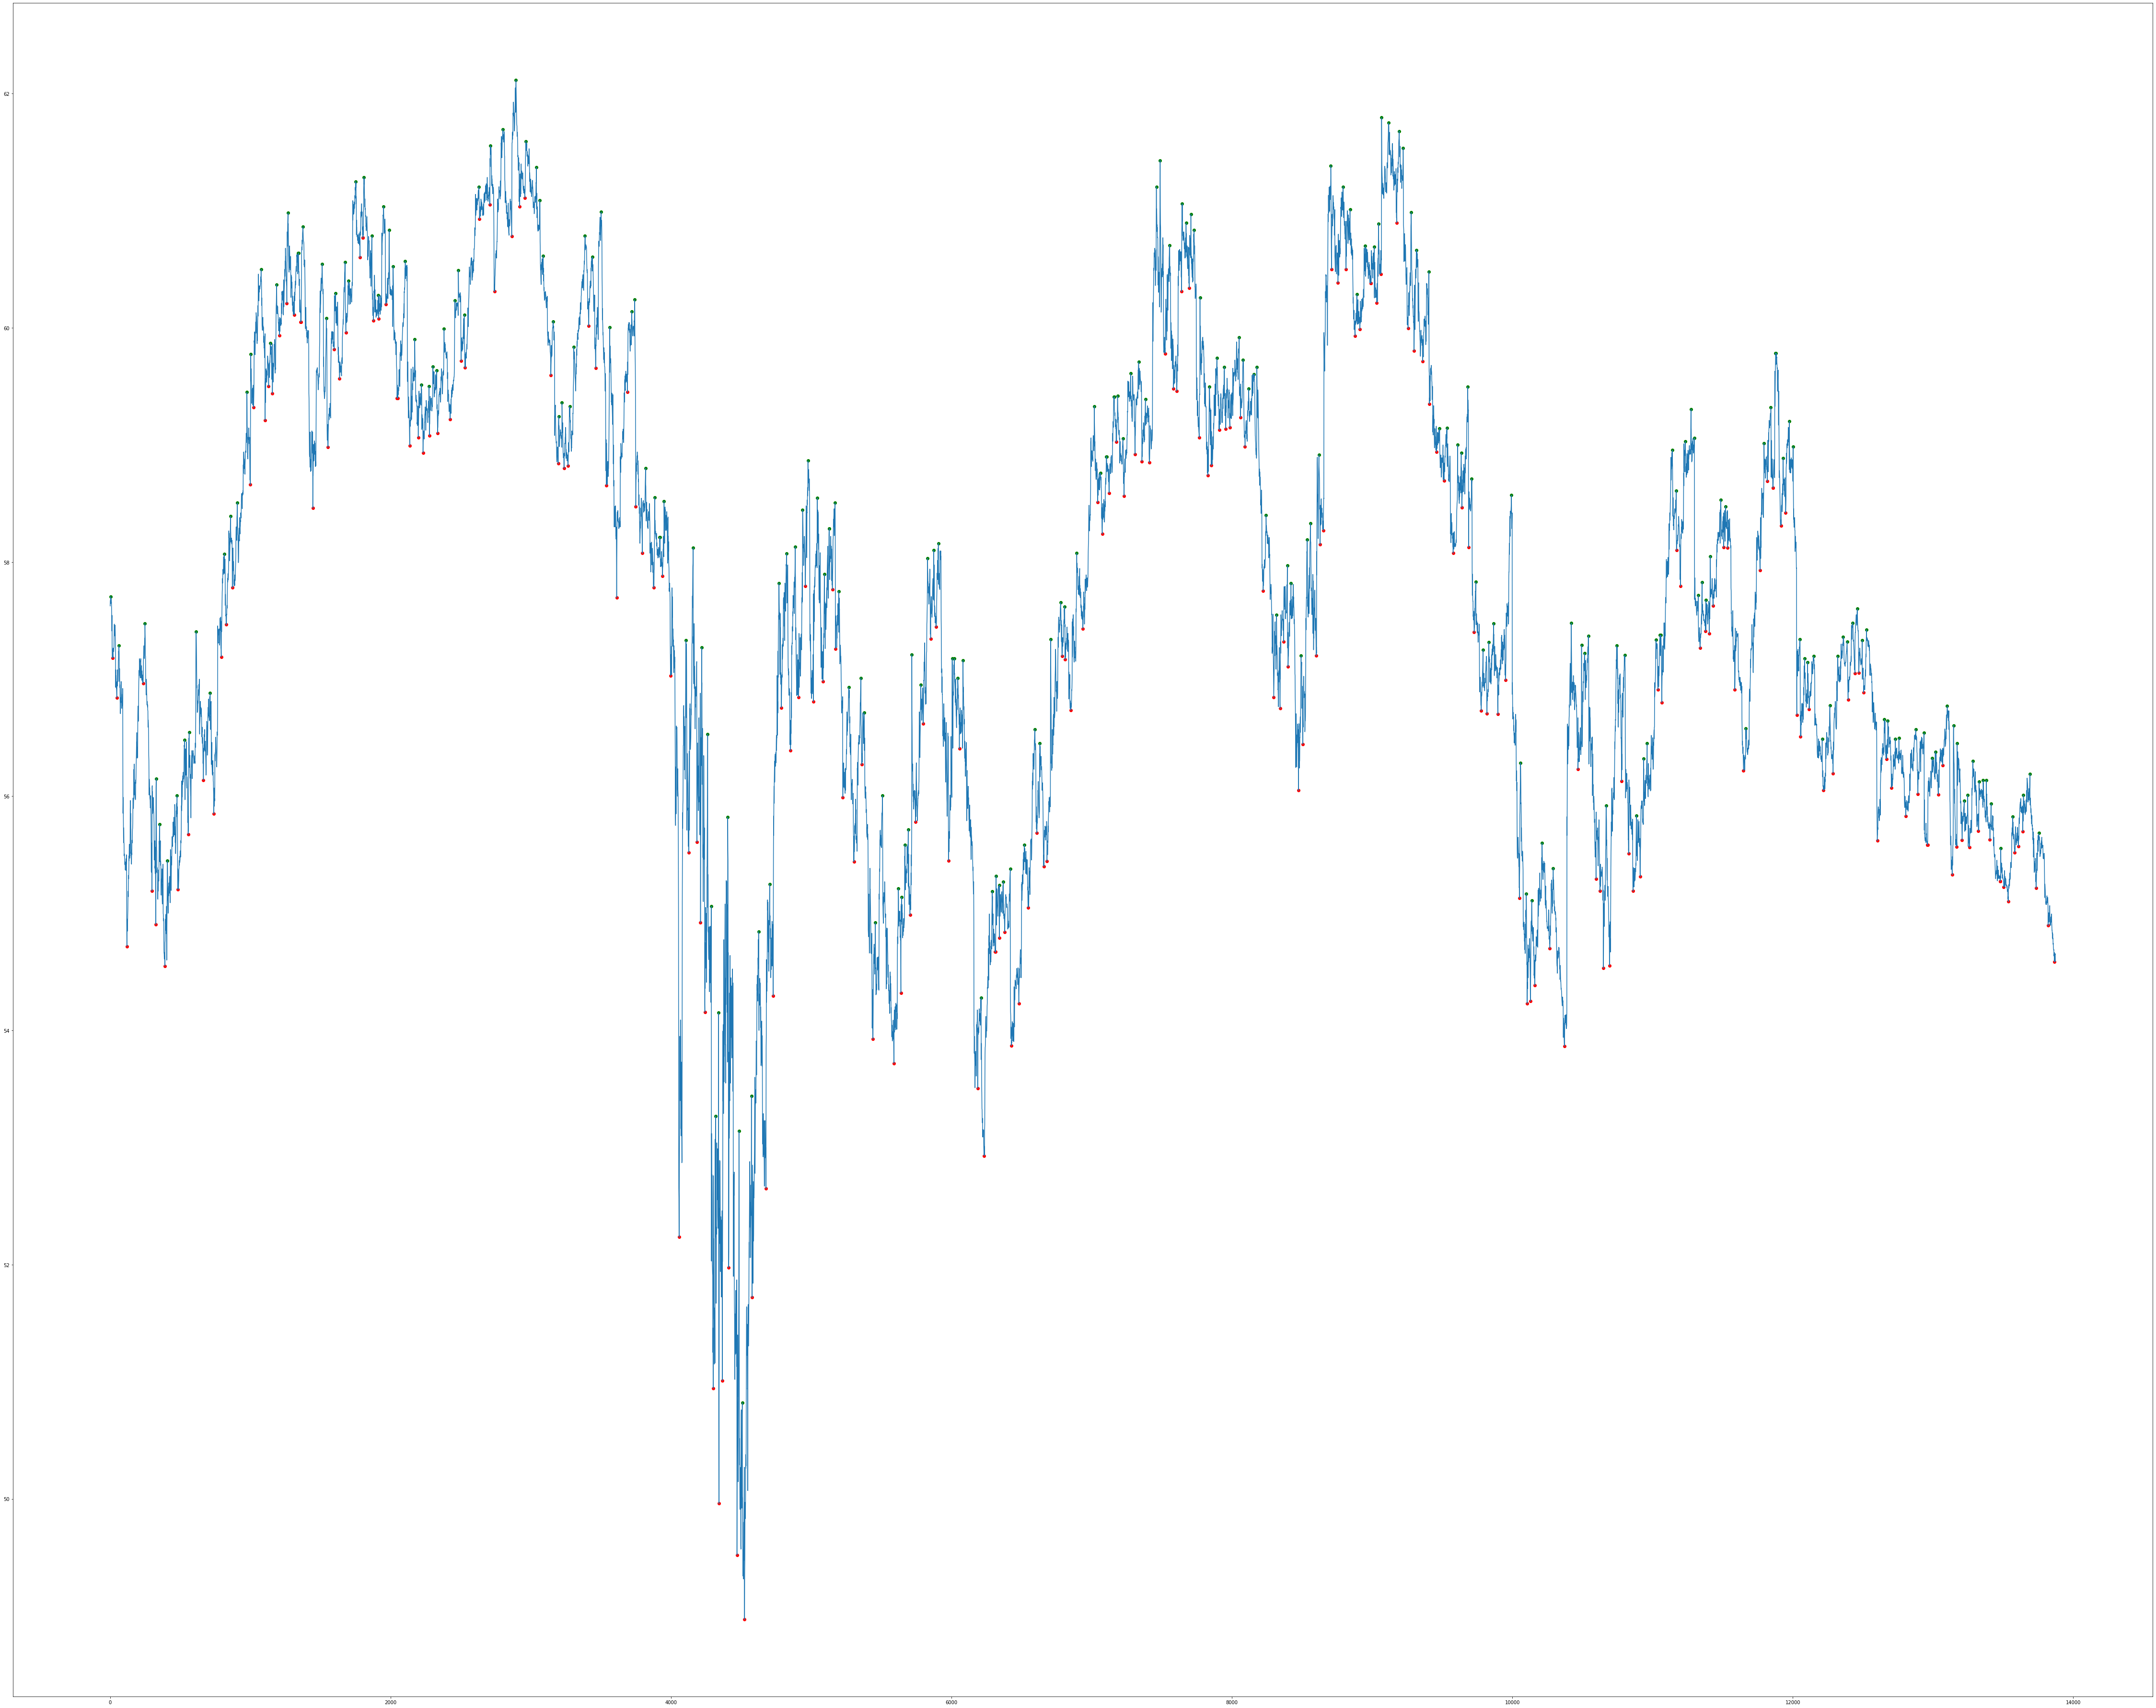

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
Min_eval_locals,Max_eval_locals=get_locals(Eval_df,n_size)

In [ ]:
''' Готовим данные для проверки, размер n_size с шагом 1'''


Eval_array=Eval_df.to_numpy()
Eval_samples=[Eval_array[i-n_size:i] for i in range(len(Eval_array)) if i-n_size>=0]
Eval_normlzd=[normalize(i, axis=0, norm='max') for i in Eval_samples]
Eval_normlzd=np.array(Eval_normlzd).reshape(-1,Eval_samples[0].shape[0],Eval_samples[0][0].shape[0],1)
print(Eval_normlzd.shape)

(13853, 20, 7, 1)


#Готовим якоря

In [ ]:
negative_anchor=[]
positve_anchor=[]



for index,i in enumerate(Y):

  if i==0:
    negative_anchor.append(X_norm[index])
  else:
    positve_anchor.append(X_norm[index])

In [ ]:
negative_anchor=np.array(negative_anchor).reshape((-1,Eval_samples[0].shape[0],Eval_samples[0][0].shape[0],1))
positve_anchor=np.array(positve_anchor).reshape((-1,Eval_samples[0].shape[0],Eval_samples[0][0].shape[0],1))
print(negative_anchor.shape,positve_anchor.shape)

(84, 20, 7, 1) (89, 20, 7, 1)


In [ ]:
Eval_normlzd[1].shape

(20, 7, 1)

#Проверка

In [ ]:
 Min_values=Min_eval_locals['min'].values
 Min_indexes=Min_eval_locals['index1'].values

In [ ]:
Min_prediction_pattern_name=[] 
date=[]
open=[]
high=[]
low=[]
close=[]
volume=[]
distance=[]
Eval_str_dates=Eval_dates['Date'].astype(str)
signal=[] #лэйбл
k=0
treshhold=0.05

In [ ]:

for indexI,eval in enumerate(Eval_normlzd[:5000]):


  



  neg_predictions=[]
  


  for neg in negative_anchor:
     neg_pred=model.predict([neg.reshape(1,20,7,1),eval.reshape(1,20,7,1)])
     neg_predictions.append(neg_pred)


  

  
  date.append(Eval_str_dates[indexI+(n_size-1)])
  open.append(float(Eval_array[indexI+(n_size-1),[0]]))
  high.append(float(Eval_array[indexI+(n_size-1),[1]]))
  low.append(float(Eval_array[indexI+(n_size-1),[2]]))
  close.append(float(Eval_array[indexI+(n_size-1),[3]]))
  volume.append(float(Eval_array[indexI+(n_size-1),[4]]))
  Min_prediction_pattern_name.append(neg_predictions.index(min(neg_predictions)))



  min_ex=min(neg_predictions)
  distance.append(float(min_ex))

  if min_ex<=treshhold:

    signal.append(1)
  else:
    signal.append(0)

 


In [ ]:


Predictions = pd.DataFrame(list(zip( date,open,high,low,close,volume,signal,Min_prediction_pattern_name,distance)),
              columns =['date','open','high','low','close','volume','signal','pattern No.','distance'])
    

Predictions.to_csv('model_test.csv')